Structured Learning:
=====================
In this exercise we will implement a structured learning system for
foreground background segmentation.
We will learn the weights of a CRF Potts model.


The first step is to  import all needed modules

In [13]:
# misc
import numpy
import sys

# visualization
import matplotlib.pyplot as plt
import pylab

# features
import skimage.filters

# discrete graphical model package
from dgm.models import *
from dgm.solvers import *
from dgm.value_tables import *
# misc. tools
from tools import make_toy_dataset, norm01

import matplotlib.pyplot as plt

from tools import make_toy_dataset, norm01

The Dataset
===============

Here we use a toy dataset where we have white squares on black background
with some noise.
The noise level is given by the variable ``noise``.


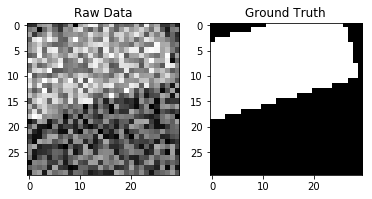

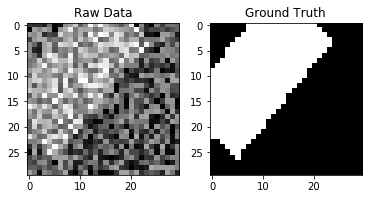

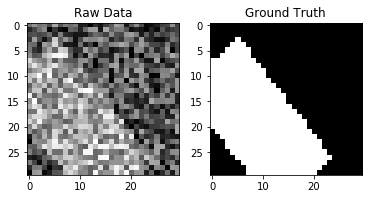

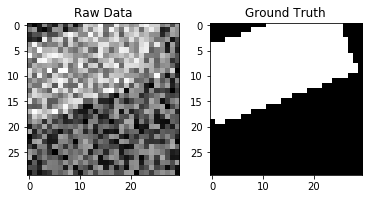

In [2]:
noise = 2.0
shape = (30,30)



x_train, y_train =  make_toy_dataset(shape=shape, n_images=5, noise=noise)
x_test , y_test  =  make_toy_dataset(shape=shape, n_images=5, noise=noise)

# show a bit from the dataset
for x in range(4):
    f= pylab.figure()
    ax1 = f.add_subplot(1,2,1)
    pylab.imshow(x_train[x],cmap='gray')
    ax1.set_title('Raw Data')

    ax2 = f.add_subplot(1,2,2)
    pylab.imshow(y_train[x],cmap='gray')
    ax2.set_title('Ground Truth')
    plt.show()

The Unary  Features (5Pt):
==============

Here you need to implement a function which should return 
pixel wise unary features.
You can use features like gaussian smooting with differnet 
sigmas.
About 5 features should be enough.

The features should be normalized to be in [0,1]



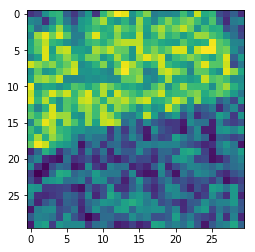

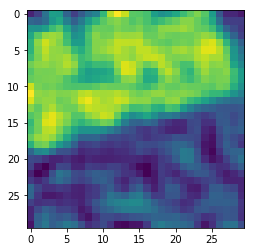

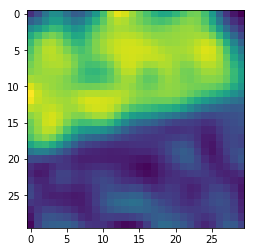

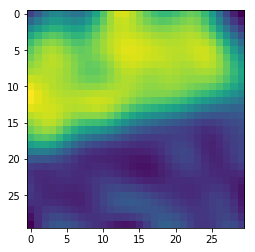

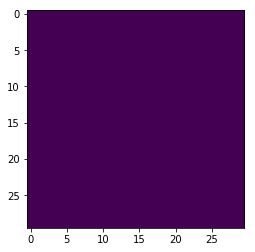

In [3]:
from skimage.morphology import disk

def get_unary_features(raw):
    features = []
    sigmas = [0.5, 1.0, 1.5, 2.0]
    for sigma in sigmas:
        n_raw = raw.copy()
        n_raw -= n_raw.min()
        n_raw /= n_raw.max()

        # smooth
        res = skimage.filters.gaussian(norm01(raw), sigma)
        features.append(res[:,:,None])
         
    
    features.append(numpy.ones(raw.shape)[:,:,None])
    return  numpy.concatenate(features, axis=2)
    


# visualize the features for a raw image
unary_features = get_unary_features(x_train[0])
n_unary_features = unary_features.shape[2]
for i in range(unary_features.shape[2]):
    pylab.imshow(unary_features[:,:,i])
    pylab.show()

The Potts Features (5 P):
==========
Here youn need to implement a function returing pixel
wise features which are used within the potts term.
The features should be something like edge detectors.

$e^{-1.0\cdot|\text{edge_strength}|} $ should work well.

You can compute edge filters on on different sigmas by presmoothing the 
raw data with a gaussian.
About five features should be enough.

The features should be normalized to be in [0,1]


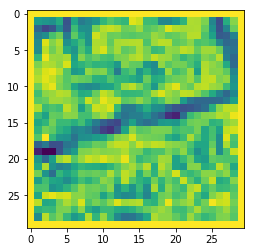

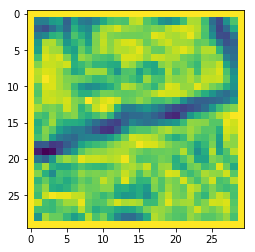

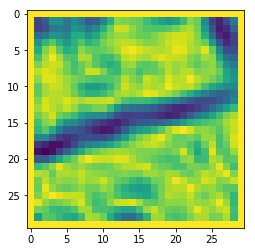

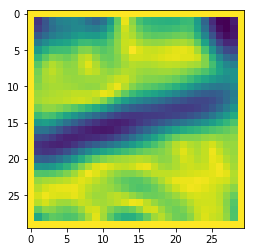

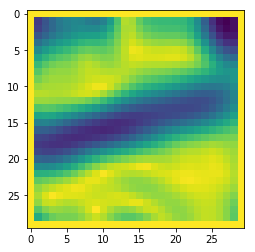

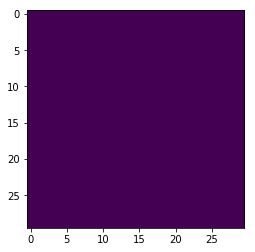

In [4]:

def get_potts_features(raw):
    features = []
    sigmas = [0.75, 1.0, 1.5, 2.5, 3.0]
    for sigma in sigmas:
        
        # pre-smooth
        s_raw = skimage.filters.gaussian(norm01(raw), sigma)
        
        edge_detector = skimage.filters.prewitt(s_raw)
        for gamma in [1.0]:
            res = norm01(numpy.exp(-gamma*edge_detector))
            features.append(res[:,:,None])

            

        
        
    features.append(numpy.ones(raw.shape)[:,:,None])
    return  numpy.concatenate(features, axis=2)


# visualize the features for a raw image
potts_features = get_potts_features(x_train[0])
n_potts_features = potts_features.shape[2]
for i in range(potts_features.shape[2]):
    pylab.imshow(potts_features[:,:,i])
    pylab.show()

Loss Function:
==========

In  this example we will use a very simple ``Hamming Loss``.

In [5]:
class HammingLoss(object):
    def __init__(self, y_true):
        self.y_true = y_true.copy()
    
    def __call__(self, y_pred):
        """total loss"""
        return numpy.sum(self.y_true!=y_pred)


Function to set up the weighted Model:
======================
This function will set up the weighted graphical model
and also the loss augmented


Model: $$\textbf{argmin}_{y} \quad w \cdot \phi(x,y) $$
Loss Augmented Model: $$\textbf{argmin}_{y} \quad w \cdot \phi(x,y)  - \Delta(\hat{y},y)$$

In [6]:
def build_model(raw_data, gt_image, weights): 
    shape = raw_data.shape
    n_var = shape[0] * shape[1]
    n_labels = 2 
    variable_space = numpy.ones(n_var)*n_labels


    # lets compute some filters for the uanry features
    unary_features = get_unary_features(raw_data)
    
    # lets compute some filters for the potts features
    potts_features = get_potts_features(raw_data)

    n_weights =potts_features.shape[2] + unary_features.shape[2]
    
    #print("n_weights",n_weights)
    assert n_weights == len(weights)


    # both graphical models
    gm = WeightedDiscreteGraphicalModel(variable_space=variable_space, weights=weights)
    loss_augmented_gm = WeightedDiscreteGraphicalModel(variable_space=variable_space, weights=weights)
    
    # convert coordinates to scalar
    def vi(x0,x1):
        return x1 + x0*shape[1]





    # weight ids for the unaries
    # (just plain numbers to remeber which weights
    # are associated with the unary features)
    weight_ids = numpy.arange(unary_features.shape[2])
    
    for x0 in range(shape[0]):
        for x1 in range(shape[1]):
            
            gt_label = gt_image[x0, x1]
            features = unary_features[x0, x1, :]

            unary_function = WeightedTwoClassUnary(features=features, weight_ids=weight_ids, 
                                                 weights=weights)

            if gt_label == 0:
                loss = numpy.array([0,1])
            else:
                loss = numpy.array([1,0])

            loss_augmented_unary_function = WeightedTwoClassUnary(features=features, weight_ids=weight_ids, 
                                                   weights=weights, const_terms=-1.0*loss)

            variables = vi(x0,x1)
            gm.add_factor(variables=variables, value_table=unary_function)
            loss_augmented_gm.add_factor(variables=variables, value_table=loss_augmented_unary_function)

    # add pairwise factors
    # the weight id's for the pairwise factors
        
    # average over 2 coordinates to extract
    # extract feature vectors for potts functins
    def get_potts_feature_vec(coord_a, coord_b):
        
        fa = potts_features[coord_a[0],coord_a[1],:]
        fb = potts_features[coord_b[0],coord_b[1],:]
        return (fa+fb)/2.0

    # weight ids for the potts functions
    # (just plain numbers to remeber which weights
    # are associated with the potts features)
    weight_ids = numpy.arange(potts_features.shape[2]) + unary_features.shape[2]

    for x0 in range(shape[0]):
        for x1 in range(shape[1]):

            # horizontal edge
            if x0 + 1 < shape[0]:
                variables = [vi(x0,x1),vi(x0+1,x1)]
                features = get_potts_feature_vec((x0,x1), (x0+1,x1))
                # the weighted potts function
                potts_function = WeightedPottsFunction(shape=[2,2],
                                                       features=features, 
                                                       weight_ids=weight_ids, 
                                                       weights=weights)
                # add factors to both models
                gm.add_factor(variables=variables, value_table=potts_function)
                loss_augmented_gm.add_factor(variables=variables, value_table=potts_function)

            # vertical edge
            if x1 + 1 < shape[1]:
                variables = [vi(x0,x1),vi(x0, x1+1)]
                features = get_potts_feature_vec((x0,x1), (x0,x1+1))
                # the weighted potts function
                potts_function = WeightedPottsFunction(shape=[2,2],
                                                       features=features, 
                                                       weight_ids=weight_ids,
                                                       weights=weights)
                # add factors to both models
                gm.add_factor(variables=variables, value_table=potts_function)
                loss_augmented_gm.add_factor(variables=variables, value_table=potts_function)
        
    # gm, loss augmented and the loss
    return gm,loss_augmented_gm, HammingLoss(gt_image.ravel())

Build the weighted models:
===============

In [7]:
#
n_weights = n_unary_features + n_potts_features
weights = numpy.zeros(n_weights)

 # build the graphical models
models_train  = [build_model(x,y, weights) for x,y in zip(x_train, y_train)]
models_test   = [build_model(x,y, weights) for x,y in zip(x_test, y_test)]


# very simple helper class to combine things
class Dataset(object):
    def __init__(self, models_train, models_test, weights):
        self.models_train = models_train
        self.models_test = models_test
        self.weights = weights
dset = Dataset(models_train, models_test, weights)



Subgradient SSVM
=========================

Instead of a cutting plane approach, we use a subgradient decent to
find the optimal weights

[Learn more about subgradient ssvm](https://www.google.de/url?sa=t&rct=j&q=&esrc=s&source=web&cd=3&cad=rja&uact=8&ved=0ahUKEwjkwJrWuPvTAhWLbVAKHWx-DQoQFgg3MAI&url=http%3A%2F%2Fwww.nowozin.net%2Fsebastian%2Fcvpr2011tutorial%2Fslides%2Ftalk-ssvm.pdf&usg=AFQjCNH6ZetauyPusXpNBWxdmZshHujgmw&sig2=q1tJ-0DgX9WuGuDIK8-eJw)

In [8]:
def subgradient_ssvm(dataset, n_iter=20, learning_rate=1.0, c=0.5, lower_bounds=None, upper_bounds=None, convergence=0.001):
    
    weights = dataset.weights
    n = len(dataset.models_train)
    
    if lower_bounds is None:
        lower_bounds = numpy.ones(len(weights))*-1.0*float('inf')

    if upper_bounds is None:
        upper_bounds = numpy.ones(len(weights))*float('inf')
    
    do_opt = True
    for iteration in range(n_iter): 

        effective_learning_rate = learning_rate*float(learning_rate)/(1.0+iteration)
        
        # compute gradient
        diff = numpy.zeros(weights.shape)
        for gm, gm_loss_augmented, loss_function in dataset.models_train:

            # update the weights to the current weight vector
            gm.change_weights(weights)
            gm_loss_augmented.change_weights(weights)

            # the gt vector
            y_true = loss_function.y_true



            # optimize loss augmented /
            # find most violated constraint
            graphcut = GraphCut(model=gm_loss_augmented)
            y_hat = graphcut.optimize()

            # compute joint feature vector
            phi_y_hat  = gm.phi(y_hat)
            phi_y_true = gm.phi(y_true)

            diff +=  phi_y_true - phi_y_hat
    
        

        new_weights = weights - effective_learning_rate*(c/n)*diff

        # project new weights 
        where_to_large = numpy.where(new_weights>upper_bounds)
        new_weights[where_to_large]  = upper_bounds[where_to_large]
        where_to_small = numpy.where(new_weights<lower_bounds)
        new_weights[where_to_small]  = lower_bounds[where_to_small]


        delta = numpy.abs(new_weights-weights).sum()
        if(delta<convergence):
            print("converged")
            break
        print('iter',iteration, 'delta',delta,"  ",numpy.round(new_weights,3))

        weights = new_weights
    

    return weights

Learn The Weights:
==========================

We call use graphcut to find the argmin of the gm and
the loss augmented gm.
Graphcut will find optimal values iff the potts regularizer is 
positive.
To ensure a positive regularizer is learned, we 
can constraint the weights of the potts function to be positive. 


In [9]:

lower_bounds = numpy.ones(len(weights))*(-1.0*float('inf'))

# we want the regularizer 'beta' to be positive
lower_bounds[n_unary_features:n_unary_features+n_potts_features] = 0
    
weights = subgradient_ssvm(dset,c=0.5,learning_rate=1.0, lower_bounds=lower_bounds, n_iter=100)


iter 0 delta 206.382182719    [-44.109 -40.103 -36.959 -34.012  51.2     0.      0.      0.      0.      0.
   0.   ]
iter 1 delta 485.044816623    [ -10.483   -8.665   -5.917   -2.964  132.45    42.743   44.53    46.558
   46.163   45.348   51.3  ]
iter 2 delta 265.617375306    [-53.904 -51.408 -48.106 -44.616  65.983  38.057  40.234  42.994  43.138
  42.239  40.833]
iter 3 delta 173.2174858    [ -32.365  -29.376  -25.704  -21.88   128.633   34.542   37.012   40.322
   40.869   39.908   32.983]
iter 4 delta 159.370425183    [-58.418 -55.022 -51.017 -46.871  88.753  31.731  34.435  38.184  39.054
  38.042  26.703]
iter 5 delta 17.0983684832    [-56.855 -53.335 -49.269 -45.078  92.937  30.737  33.5    37.368  38.341
  37.327  24.753]
iter 6 delta 12.0820352929    [-55.91  -52.288 -48.172 -43.944  95.608  29.891  32.701  36.668  37.734
  36.721  23.125]
iter 7 delta 9.0283303174    [-55.249 -51.546 -47.395 -43.142  97.458  29.202  32.043  36.092  37.232
  36.222  21.85 ]
iter 8 delta 7.7

iter 63 delta 0.341102953047    [ -55.065  -50.281  -45.685  -41.147  103.04    20.771   23.908   28.655
   30.359   29.254    5.845]
iter 64 delta 0.335855215308    [ -55.071  -50.281  -45.683  -41.144  103.044   20.722   23.86    28.61
   30.316   29.21     5.755]
iter 65 delta 0.330766499925    [ -55.077  -50.28   -45.68   -41.14   103.049   20.674   23.813   28.565
   30.273   29.166    5.667]
iter 66 delta 0.325829686493    [ -55.083  -50.28   -45.678  -41.137  103.053   20.626   23.767   28.522
   30.231   29.123    5.581]
iter 67 delta 0.321038073456    [ -55.089  -50.28   -45.676  -41.133  103.058   20.579   23.721   28.479
   30.189   29.081    5.496]
iter 68 delta 0.351618961442    [ -55.104  -50.289  -45.683  -41.139  103.045   20.533   23.675   28.436
   30.149   29.04     5.412]
iter 69 delta 0.311865557072    [ -55.11   -50.288  -45.68   -41.136  103.049   20.487   23.631   28.394
   30.108   28.999    5.329]
iter 70 delta 0.344283024442    [ -55.126  -50.299  -45.69   -4

Training Set Performance:
===============

learnedn weights [ -55.43789218  -50.48074992  -45.82858813  -41.26015908  102.75082252
   19.38446581   22.55365332   27.36961213   29.12162527   27.99866316
    3.38343451]


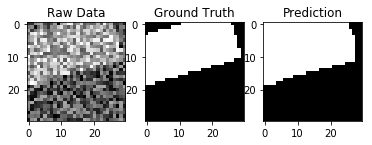

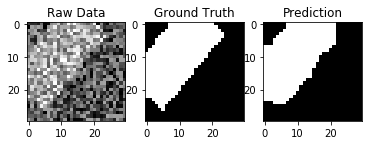

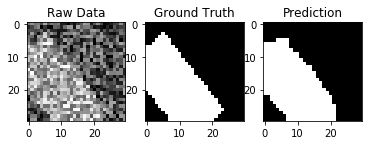

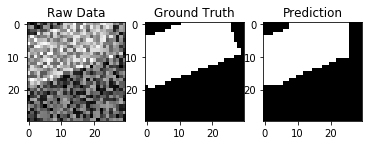

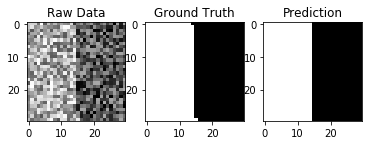

In [12]:
print("learnedn weights",weights)
for i,(gm,_,loss_function) in enumerate(models_train):
    gm.change_weights(weights)
    
    
    graphcut = GraphCut(model=gm)
    y_pred = graphcut.optimize()
    
    prediction_image = y_pred.reshape(shape)
    
    # show a bit from the dataset
   
    f= pylab.figure()
    ax1 = f.add_subplot(1,3,1)
    pylab.imshow(x_train[i],cmap='gray')
    ax1.set_title('Raw Data')
    
    ax2 = f.add_subplot(1,3,2)
    pylab.imshow(y_train[i],cmap='gray')
    ax2.set_title('Ground Truth')
 
    ax3 = f.add_subplot(1,3,3)
    pylab.imshow(prediction_image,cmap='gray')
    ax3.set_title('Prediction')
    
    plt.show()

    
            

Test set performance:
==============

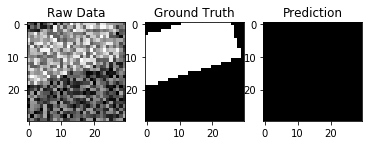

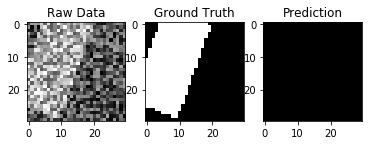

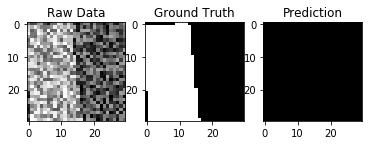

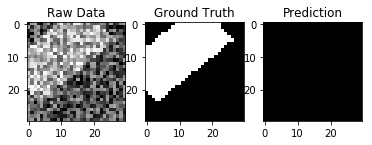

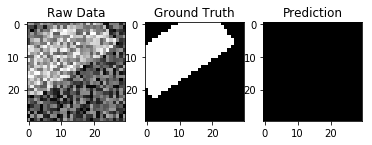

In [14]:
for i,(gm,_,loss_function) in enumerate(models_test):
    gm.change_weights(weights)
    
 
    graphcut = GraphCut(model=gm)
    y_pred = graphcut.optimize()
    
    prediction_image = y_pred.reshape(shape)
    
    # show a bit from the dataset
   
    f= pylab.figure()
    ax1 = f.add_subplot(1,3,1)
    pylab.imshow(x_test[i],cmap='gray')
    ax1.set_title('Raw Data')
    
    ax2 = f.add_subplot(1,3,2)
    pylab.imshow(y_test[i],cmap='gray')
    ax2.set_title('Ground Truth')
 
    ax3 = f.add_subplot(1,3,3)
    pylab.imshow(prediction_image,cmap='gray')
    ax3.set_title('Prediction')
    
    plt.show()



Experiments (5 P):
=============
Compute The test set performance (loss on test test) for different noise values
(1.5, 2.0, 2.5, 3.0, 3.5)  and different regularizers C (0.1 0.5 0.9, 5, 10).

Experiments (5 P):
=============
Replace GraphCut with IteratedConditionalModes (ICM) to see if optimality is important.

Bonus (5 P):
=============
show the test set and training set performance in each n'th
iteration during training.
